In [2]:
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
import os

In [3]:
# Step 3: Load and Parse JSON Data (Focused on related_topics)
def load_json_data(file_paths):
    """
    Loads and parses JSON files, recursively extracting 'question', 'related_topics', 'intent', and 'type'.
    This function is made more robust to handle varied nesting levels.
    """
    all_data = []

    def extract_qa_items(obj):
        if isinstance(obj, dict):
            # Check for core fields based on user's provided structure
            if 'question' in obj and 'related_topics' in obj and 'intent' in obj and 'type' in obj:
                item = {
                    'question': obj['question'],
                    'related_topics': obj['related_topics'],
                    'intent': obj['intent'],
                    'type': obj['type']
                }
                all_data.append(item)
            else:
                # Recurse into dictionary values
                for key, value in obj.items():
                    extract_qa_items(value)
        elif isinstance(obj, list):
            # Recurse into list elements
            for item in obj:
                extract_qa_items(item)

    for file_path in file_paths:
        try:
            # Directly read the JSON file
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                extract_qa_items(data)
        except FileNotFoundError:
            print(f"Error: {file_path} not found.")
        except json.JSONDecodeError:
            print(f"Error: Could not decode JSON from {file_path}.")
        except Exception as e:
            print(f"An unexpected error occurred while processing {file_path}: {e}")

    return pd.DataFrame(all_data) if all_data else pd.DataFrame()

# Define file paths (ensure these match your uploaded JSONs)
file_paths = [
    r'D:\OWASP_BERT\QA_Pairs\Enhanced_QA\A01_2021.json',
    r'D:\OWASP_BERT\QA_Pairs\Enhanced_QA\A02_2021.json',
    r'D:\OWASP_BERT\QA_Pairs\Enhanced_QA\A03_2021.json',
    r'D:\OWASP_BERT\QA_Pairs\Enhanced_QA\A04_2021.json',
    r'D:\OWASP_BERT\QA_Pairs\Enhanced_QA\A05_2021.json',
    r'D:\OWASP_BERT\QA_Pairs\Enhanced_QA\A06_2021.json',
    r'D:\OWASP_BERT\QA_Pairs\Enhanced_QA\A07_2021.json',
    r'D:\OWASP_BERT\QA_Pairs\Enhanced_QA\A08_2021.json',
    r'D:\OWASP_BERT\QA_Pairs\Enhanced_QA\A09_2021.json',
    r'D:\OWASP_BERT\QA_Pairs\Enhanced_QA\A10_2021.json'
]

# Load data into a DataFrame
df = load_json_data(file_paths)

if df.empty:
    print("No Q&A data loaded for knowledge graph. Please ensure JSON files are correct and present.")
    exit()

print(f"Loaded {len(df)} Q&A entries from JSON files for knowledge graph creation.")
print("\nDataFrame Head (includes 'related_topics'):")
print(df.head())

# Filter out rows where 'related_topics' is empty or not a list
if not df.empty:
    df_filtered_topics = df[df['related_topics'].apply(lambda x: isinstance(x, list) and len(x) > 0)].copy()
    print(f"\nDataFrame shape after filtering for non-empty related_topics: {df_filtered_topics.shape}")
else:
    print("\nNo data available for filtering.")

Loaded 3774 Q&A entries from JSON files for knowledge graph creation.

DataFrame Head (includes 'related_topics'):
                                            question related_topics  \
0  What does 'Broken Access Control' refer to in ...             []   
1  What does 'Broken Access Control' refer to in ...             []   
2  What does 'Broken Access Control' refer to in ...             []   
3  What does 'Broken Access Control' refer to in ...             []   
4  What does 'Broken Access Control' refer to in ...             []   

                         intent                 type  
0  define_broken_access_control  basic_understanding  
1  define_broken_access_control  basic_understanding  
2  define_broken_access_control  basic_understanding  
3  define_broken_access_control  basic_understanding  
4  define_broken_access_control  basic_understanding  

DataFrame shape after filtering for non-empty related_topics: (3761, 4)


In [4]:
# Step 4: Build the Knowledge Graph
# Initialize an empty graph
KG = nx.Graph()

# Add nodes (topics) and edges based on co-occurrence within 'related_topics' lists
for index, row in df_filtered_topics.iterrows():
    topics = row['related_topics']
    # Add nodes for each topic
    for topic in topics:
        if topic not in KG:
            KG.add_node(topic, type='topic') # Assign a 'type' attribute to nodes

    # Add edges between co-occurring topics in the same Q&A entry
    # This creates a "co-occurrence graph" based on your data
    for i in range(len(topics)):
        for j in range(i + 1, len(topics)):
            topic1 = topics[i]
            topic2 = topics[j]
            if KG.has_edge(topic1, topic2):
                KG[topic1][topic2]['weight'] += 1 # Increase weight if edge already exists
            else:
                KG.add_edge(topic1, topic2, weight=1) # Add edge with weight 1

print(f"\nKnowledge Graph created with {KG.number_of_nodes()} nodes and {KG.number_of_edges()} edges.")
print("\nExample Nodes (first 5):")
print(list(KG.nodes())[:5])
print("\nExample Edges (first 5):")
print(list(KG.edges(data=True))[:5])


Knowledge Graph created with 2802 nodes and 9536 edges.

Example Nodes (first 5):
['least_privilege', 'risk', 'api_security', 'development_practices', 'security_through_obscurity']

Example Edges (first 5):
[('least_privilege', 'role_based_access_control', {'weight': 1}), ('least_privilege', 'access_control', {'weight': 3}), ('least_privilege', 'security_policy', {'weight': 1}), ('api_security', 'jwt', {'weight': 1}), ('api_security', 'cors', {'weight': 1})]


In [5]:
# Step 5: Save the Knowledge Graph
# Save the graph in GraphML format (a common XML-based format for graphs)
graph_save_path = "./security_knowledge_graph.gml"
try:
    nx.write_gml(KG, graph_save_path)
    print(f"\nKnowledge Graph saved to: {graph_save_path}")
except Exception as e:
    print(f"Error saving graph: {e}")



Knowledge Graph saved to: ./security_knowledge_graph.gml



--- Visualizing a Subset of the Knowledge Graph ---


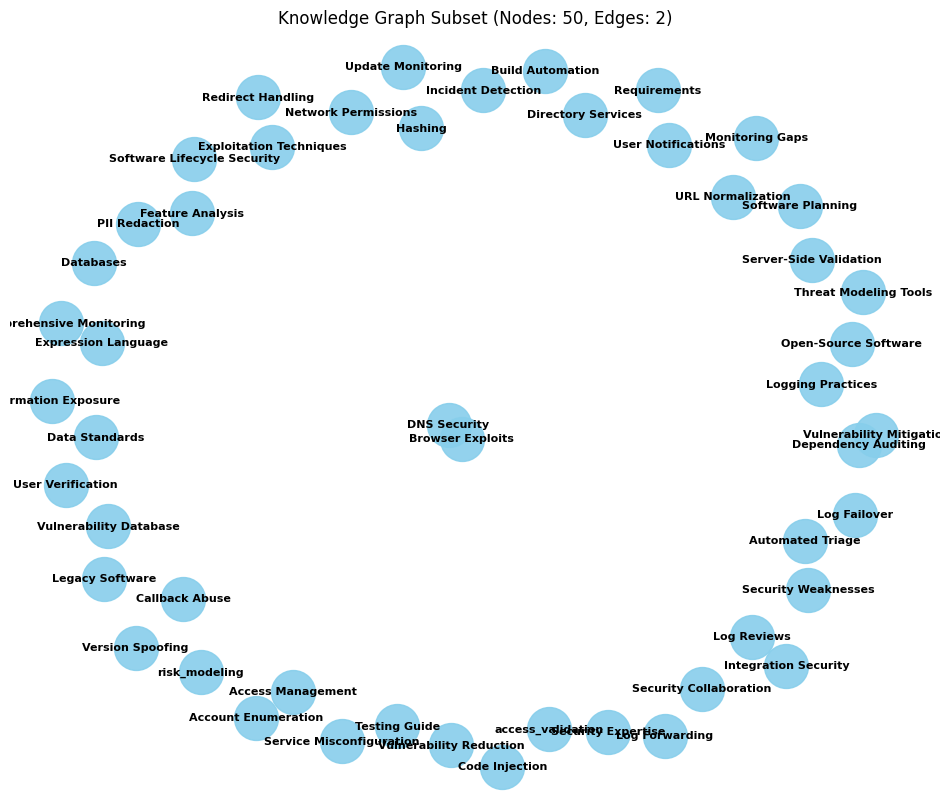


Stage 3: Knowledge graph creation complete.
The created graph can now be used for contextual suggestions and deeper insights in the chatbot.


In [6]:
# Step 6: Basic Visualization of a Subset of the Knowledge Graph
print("\n--- Visualizing a Subset of the Knowledge Graph ---")
# Due to the large number of nodes, we'll visualize only a small, connected component
# or a subgraph around a central topic.

# Find the largest connected component
if nx.is_connected(KG):
    main_component = KG
else:
    main_component = KG.subgraph(max(nx.connected_components(KG), key=len))

# Select a subset of nodes from the main component for visualization
# For demonstration, we'll pick nodes related to 'access_control' if available
central_topic = 'access_control'
subgraph_nodes = set()

if central_topic in main_component:
    # Add the central topic
    subgraph_nodes.add(central_topic)
    # Add its direct neighbors
    subgraph_nodes.update(main_component.neighbors(central_topic))
    # Optionally, add neighbors of neighbors for a slightly larger view
    for neighbor in list(main_component.neighbors(central_topic)):
        subgraph_nodes.update(main_component.neighbors(neighbor))

# If central topic not found or subgraph too small, just take a random sample
if len(subgraph_nodes) < 10 and main_component.number_of_nodes() > 10:
    import random
    subgraph_nodes = set(random.sample(list(main_component.nodes()), min(50, main_component.number_of_nodes())))
elif main_component.number_of_nodes() > 50:
    # If the graph is still very large, take a smaller random sample
    import random
    subgraph_nodes = set(random.sample(list(main_component.nodes()), 50))


sub_KG = KG.subgraph(subgraph_nodes)

if sub_KG.number_of_nodes() > 1:
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(sub_KG, k=0.15, iterations=50) # spring_layout for aesthetic layout
    
    # Draw nodes
    nx.draw_networkx_nodes(sub_KG, pos, node_size=1000, node_color='skyblue', alpha=0.9)
    
    # Draw edges, thicker for higher weight (more frequent co-occurrence)
    edges = sub_KG.edges(data=True)
    weights = [d['weight'] for u, v, d in edges]
    nx.draw_networkx_edges(sub_KG, pos, edgelist=edges, width=[w * 0.5 for w in weights], alpha=0.5, edge_color='gray')
    
    # Draw labels
    nx.draw_networkx_labels(sub_KG, pos, font_size=8, font_weight='bold')
    
    plt.title(f"Knowledge Graph Subset (Nodes: {sub_KG.number_of_nodes()}, Edges: {sub_KG.number_of_edges()})")
    plt.axis('off')
    plt.show()
else:
    print("Graph is too small or isolated for meaningful visualization in this example.")


print("\nStage 3: Knowledge graph creation complete.")
print("The created graph can now be used for contextual suggestions and deeper insights in the chatbot.")

In [7]:
# Step 7: Testing the Knowledge Graph (Querying)
print("\n--- Testing the Knowledge Graph (Querying) ---")

def test_knowledge_graph(graph):
    print("\n--- Basic Graph Information ---")
    print(f"Total Nodes: {graph.number_of_nodes()}")
    print(f"Total Edges: {graph.number_of_edges()}")

    # Test 1: Check for specific nodes
    test_topics = ['access_control', 'encryption', 'vulnerability_assessment', 'threat_modeling']
    print("\n--- Checking for Specific Topics (Nodes) ---")
    for topic in test_topics:
        if topic in graph:
            print(f"'{topic}' exists in the graph.")
            print(f"  Neighbors of '{topic}': {list(graph.neighbors(topic))[:5]}...") # Show first 5 neighbors
        else:
            print(f"'{topic}' does NOT exist in the graph.")

    # Test 2: Check for specific edges and their weights
    print("\n--- Checking for Specific Relationships (Edges) ---")
    test_edges = [
        ('access_control', 'privilege_management'),
        ('encryption', 'key_management'),
        ('vulnerability_assessment', 'penetration_testing')
    ]
    for u, v in test_edges:
        if graph.has_edge(u, v):
            weight = graph[u][v]['weight']
            print(f"Edge '{u}'--'{v}' exists with weight: {weight}")
        else:
            print(f"Edge '{u}'--'{v}' does NOT exist.")

    # Test 3: Find paths between topics
    print("\n--- Finding Paths Between Topics ---")
    path_queries = [
        ('access_control', 'security_policies'),
        ('encryption', 'token_security'),
        ('threat_modeling', 'risk_assessment')
    ]
    for source, target in path_queries:
        if source in graph and target in graph:
            try:
                # Find shortest path
                path = nx.shortest_path(graph, source=source, target=target)
                print(f"Shortest path from '{source}' to '{target}': {path}")
            except nx.NetworkXNoPath:
                print(f"No path found between '{source}' and '{target}'.")
            except Exception as e:
                print(f"Error finding path between '{source}' and '{target}': {e}")
        else:
            print(f"Either '{source}' or '{target}' (or both) not found in the graph.")

    # Test 4: Find common neighbors
    print("\n--- Finding Common Neighbors ---")
    common_neighbor_queries = [
        ('access_control', 'privilege_management'),
        ('encryption', 'token_security')
    ]
    for u, v in common_neighbor_queries:
        if u in graph and v in graph:
            common_nodes = list(nx.common_neighbors(graph, u, v))
            print(f"Common neighbors of '{u}' and '{v}': {common_nodes[:5]}...") # Show first 5
        else:
            print(f"Either '{u}' or '{v}' (or both) not found in the graph.")

# Run the test function after the graph has been built
test_knowledge_graph(KG)
print("\nKnowledge Graph testing complete.")


--- Testing the Knowledge Graph (Querying) ---

--- Basic Graph Information ---
Total Nodes: 2802
Total Edges: 9536

--- Checking for Specific Topics (Nodes) ---
'access_control' exists in the graph.
  Neighbors of 'access_control': ['authorization_services', 'automated_scanning', 'client_side_security', 'resource_hierarchy', 'network_analysis']...
'encryption' exists in the graph.
  Neighbors of 'encryption': ['token_security', 'session_management', 'sensitive_data_exposure', 'hashing', 'key_management']...
'vulnerability_assessment' exists in the graph.
  Neighbors of 'vulnerability_assessment': ['risk_modeling', 'broken_access_control', 'penetration_testing', 'security_compliance']...
'threat_modeling' exists in the graph.
  Neighbors of 'threat_modeling': ['security_design']...

--- Checking for Specific Relationships (Edges) ---
Edge 'access_control'--'privilege_management' exists with weight: 2
Edge 'encryption'--'key_management' exists with weight: 1
Edge 'vulnerability_assessm